In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-sales-forecast/features.csv
/kaggle/input/walmart-sales-forecast/stores.csv
/kaggle/input/walmart-sales-forecast/train.csv
/kaggle/input/walmart-sales-forecast/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.special import boxcox1p
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn import set_config
set_config(display='diagram')

In [3]:
features=pd.read_csv("/kaggle/input/walmart-sales-forecast/features.csv")
store=pd.read_csv("/kaggle/input/walmart-sales-forecast/stores.csv")
train=pd.read_csv("/kaggle/input/walmart-sales-forecast/train.csv")
test=pd.read_csv("/kaggle/input/walmart-sales-forecast/test.csv")

In [4]:
features

Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0         1  2010-02-05        42.31       2.572        NaN        NaN   
1         1  2010-02-12        38.51       2.548        NaN        NaN   
2         1  2010-02-19        39.93       2.514        NaN        NaN   
3         1  2010-02-26        46.63       2.561        NaN        NaN   
4         1  2010-03-05        46.50       2.625        NaN        NaN   
...     ...         ...          ...         ...        ...        ...   
8185     45  2013-06-28        76.05       3.639    4842.29     975.03   
8186     45  2013-07-05        77.50       3.614    9090.48    2268.58   
8187     45  2013-07-12        79.37       3.614    3789.94    1827.31   
8188     45  2013-07-19        82.84       3.737    2961.49    1047.07   
8189     45  2013-07-26        76.06       3.804     212.02     851.73   

      MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0           NaN        NaN        NaN  211.096358         8.106      False  
1           NaN        NaN        NaN  211.242170         8.106       True  
2           NaN        NaN        NaN  211.289143         8.106      False  
3           NaN        NaN        NaN  211.319643         8.106      False  
4           NaN        NaN        NaN  211.350143         8.106      False  
...         ...        ...        ...         ...           ...        ...  
8185       3.00    2449.97    3169.69         NaN           NaN      False  
8186     582.74    5797.47    1514.93         NaN           NaN      False  
8187      85.72     744.84    2150.36         NaN           NaN      False  
8188     204.19     363.00    1059.46         NaN           NaN      False  
8189       2.06      10.88    1864.57         NaN           NaN      False  

[8190 rows x 12 columns]

In [5]:
store

Store Type    Size
0       1    A  151315
1       2    A  202307
2       3    B   37392
3       4    A  205863
4       5    B   34875
5       6    A  202505
6       7    B   70713
7       8    A  155078
8       9    B  125833
9      10    B  126512
10     11    A  207499
11     12    B  112238
12     13    A  219622
13     14    A  200898
14     15    B  123737
15     16    B   57197
16     17    B   93188
17     18    B  120653
18     19    A  203819
19     20    A  203742
20     21    B  140167
21     22    B  119557
22     23    B  114533
23     24    A  203819
24     25    B  128107
25     26    A  152513
26     27    A  204184
27     28    A  206302
28     29    B   93638
29     30    C   42988
30     31    A  203750
31     32    A  203007
32     33    A   39690
33     34    A  158114
34     35    B  103681
35     36    A   39910
36     37    C   39910
37     38    C   39690
38     39    A  184109
39     40    A  155083
40     41    A  196321
41     42    C   39690
42     43    C   41062
43     44    C   39910
44     45    B  118221

In [6]:
test

Store  Dept        Date  IsHoliday
0           1     1  2012-11-02      False
1           1     1  2012-11-09      False
2           1     1  2012-11-16      False
3           1     1  2012-11-23       True
4           1     1  2012-11-30      False
...       ...   ...         ...        ...
115059     45    98  2013-06-28      False
115060     45    98  2013-07-05      False
115061     45    98  2013-07-12      False
115062     45    98  2013-07-19      False
115063     45    98  2013-07-26      False

[115064 rows x 4 columns]

In [7]:
train

Store  Dept        Date  Weekly_Sales  IsHoliday
0           1     1  2010-02-05      24924.50      False
1           1     1  2010-02-12      46039.49       True
2           1     1  2010-02-19      41595.55      False
3           1     1  2010-02-26      19403.54      False
4           1     1  2010-03-05      21827.90      False
...       ...   ...         ...           ...        ...
421565     45    98  2012-09-28        508.37      False
421566     45    98  2012-10-05        628.10      False
421567     45    98  2012-10-12       1061.02      False
421568     45    98  2012-10-19        760.01      False
421569     45    98  2012-10-26       1076.80      False

[421570 rows x 5 columns]

In [8]:
train=train.groupby(['Store','Date'])['Weekly_Sales'].sum()
train=train.reset_index()
train.head(10)

Store        Date  Weekly_Sales
0      1  2010-02-05    1643690.90
1      1  2010-02-12    1641957.44
2      1  2010-02-19    1611968.17
3      1  2010-02-26    1409727.59
4      1  2010-03-05    1554806.68
5      1  2010-03-12    1439541.59
6      1  2010-03-19    1472515.79
7      1  2010-03-26    1404429.92
8      1  2010-04-02    1594968.28
9      1  2010-04-09    1545418.53

In [9]:
data=pd.merge(train,features,on=['Store','Date'],how='inner')
data.head(10)
data

Store        Date  Weekly_Sales  Temperature  Fuel_Price  MarkDown1  \
0         1  2010-02-05    1643690.90        42.31       2.572        NaN   
1         1  2010-02-12    1641957.44        38.51       2.548        NaN   
2         1  2010-02-19    1611968.17        39.93       2.514        NaN   
3         1  2010-02-26    1409727.59        46.63       2.561        NaN   
4         1  2010-03-05    1554806.68        46.50       2.625        NaN   
...     ...         ...           ...          ...         ...        ...   
6430     45  2012-09-28     713173.95        64.88       3.997    4556.61   
6431     45  2012-10-05     733455.07        64.89       3.985    5046.74   
6432     45  2012-10-12     734464.36        54.47       4.000    1956.28   
6433     45  2012-10-19     718125.53        56.47       3.969    2004.02   
6434     45  2012-10-26     760281.43        58.85       3.882    4018.91   

      MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  \
0           NaN        NaN        NaN        NaN  211.096358         8.106   
1           NaN        NaN        NaN        NaN  211.242170         8.106   
2           NaN        NaN        NaN        NaN  211.289143         8.106   
3           NaN        NaN        NaN        NaN  211.319643         8.106   
4           NaN        NaN        NaN        NaN  211.350143         8.106   
...         ...        ...        ...        ...         ...           ...   
6430      20.64       1.50    1601.01    3288.25  192.013558         8.684   
6431        NaN      18.82    2253.43    2340.01  192.170412         8.667   
6432        NaN       7.89     599.32    3990.54  192.327265         8.667   
6433        NaN       3.18     437.73    1537.49  192.330854         8.667   
6434      58.08     100.00     211.94     858.33  192.308899         8.667   

      IsHoliday  
0         False  
1          True  
2         False  
3         False  
4         False  
...         ...  
6430      False  
6431      False  
6432      False  
6433      False  
6434      False  

[6435 rows x 13 columns]

In [10]:
data=pd.merge(data,store,on=['Store'],how='inner')
data.head(10)
data

Store        Date  Weekly_Sales  Temperature  Fuel_Price  MarkDown1  \
0         1  2010-02-05    1643690.90        42.31       2.572        NaN   
1         1  2010-02-12    1641957.44        38.51       2.548        NaN   
2         1  2010-02-19    1611968.17        39.93       2.514        NaN   
3         1  2010-02-26    1409727.59        46.63       2.561        NaN   
4         1  2010-03-05    1554806.68        46.50       2.625        NaN   
...     ...         ...           ...          ...         ...        ...   
6430     45  2012-09-28     713173.95        64.88       3.997    4556.61   
6431     45  2012-10-05     733455.07        64.89       3.985    5046.74   
6432     45  2012-10-12     734464.36        54.47       4.000    1956.28   
6433     45  2012-10-19     718125.53        56.47       3.969    2004.02   
6434     45  2012-10-26     760281.43        58.85       3.882    4018.91   

      MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  \
0           NaN        NaN        NaN        NaN  211.096358         8.106   
1           NaN        NaN        NaN        NaN  211.242170         8.106   
2           NaN        NaN        NaN        NaN  211.289143         8.106   
3           NaN        NaN        NaN        NaN  211.319643         8.106   
4           NaN        NaN        NaN        NaN  211.350143         8.106   
...         ...        ...        ...        ...         ...           ...   
6430      20.64       1.50    1601.01    3288.25  192.013558         8.684   
6431        NaN      18.82    2253.43    2340.01  192.170412         8.667   
6432        NaN       7.89     599.32    3990.54  192.327265         8.667   
6433        NaN       3.18     437.73    1537.49  192.330854         8.667   
6434      58.08     100.00     211.94     858.33  192.308899         8.667   

      IsHoliday Type    Size  
0         False    A  151315  
1          True    A  151315  
2         False    A  151315  
3         False    A  151315  
4         False    A  151315  
...         ...  ...     ...  
6430      False    B  118221  
6431      False    B  118221  
6432      False    B  118221  
6433      False    B  118221  
6434      False    B  118221  

[6435 rows x 15 columns]

<AxesSubplot:xlabel='Type', ylabel='count'>

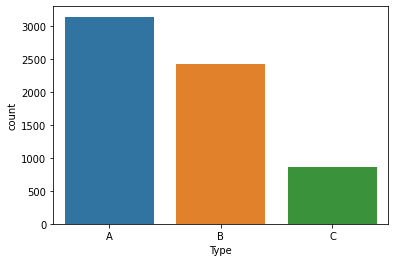

In [11]:
sns.countplot(x="Type", data=data)

<AxesSubplot:xlabel='Type', ylabel='Weekly_Sales'>

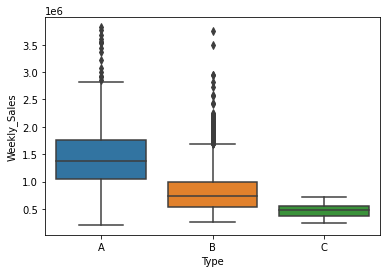

In [12]:
sns.boxplot(x='Type',y='Weekly_Sales',data=data)

<AxesSubplot:ylabel='Frequency'>

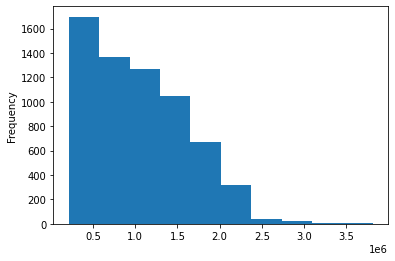

In [13]:
data["Weekly_Sales"].plot.hist()

<AxesSubplot:xlabel='IsHoliday', ylabel='count'>

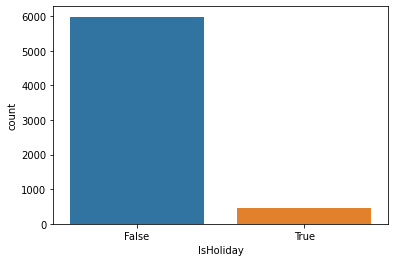

In [14]:
sns.countplot(x="IsHoliday", data=data)

In [15]:
data.isnull().sum()

Store              0
Date               0
Weekly_Sales       0
Temperature        0
Fuel_Price         0
MarkDown1       4155
MarkDown2       4798
MarkDown3       4389
MarkDown4       4470
MarkDown5       4140
CPI                0
Unemployment       0
IsHoliday          0
Type               0
Size               0
dtype: int64

<AxesSubplot:>

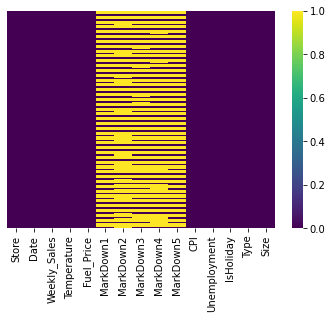

In [16]:
sns.heatmap(data.isnull(),yticklabels=False, cmap="viridis")


In [17]:
data=data.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],axis=1)
data.head(10)

Store        Date  Weekly_Sales  Temperature  Fuel_Price         CPI  \
0      1  2010-02-05    1643690.90        42.31       2.572  211.096358   
1      1  2010-02-12    1641957.44        38.51       2.548  211.242170   
2      1  2010-02-19    1611968.17        39.93       2.514  211.289143   
3      1  2010-02-26    1409727.59        46.63       2.561  211.319643   
4      1  2010-03-05    1554806.68        46.50       2.625  211.350143   
5      1  2010-03-12    1439541.59        57.79       2.667  211.380643   
6      1  2010-03-19    1472515.79        54.58       2.720  211.215635   
7      1  2010-03-26    1404429.92        51.45       2.732  211.018042   
8      1  2010-04-02    1594968.28        62.27       2.719  210.820450   
9      1  2010-04-09    1545418.53        65.86       2.770  210.622857   

   Unemployment  IsHoliday Type    Size  
0         8.106      False    A  151315  
1         8.106       True    A  151315  
2         8.106      False    A  151315  
3         8.106      False    A  151315  
4         8.106      False    A  151315  
5         8.106      False    A  151315  
6         8.106      False    A  151315  
7         8.106      False    A  151315  
8         7.808      False    A  151315  
9         7.808      False    A  151315

In [18]:
data.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
IsHoliday       0
Type            0
Size            0
dtype: int64

<AxesSubplot:>

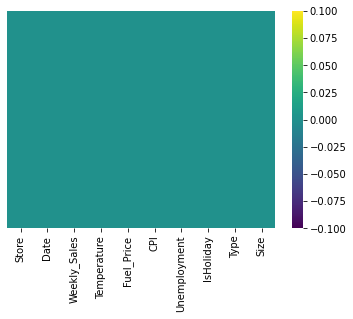

In [19]:
sns.heatmap(data.isnull(),yticklabels=False, cmap="viridis")

In [20]:
data['Holiday']=[int(i) for i in list(data.IsHoliday)]
data.head(10)

Store        Date  Weekly_Sales  Temperature  Fuel_Price         CPI  \
0      1  2010-02-05    1643690.90        42.31       2.572  211.096358   
1      1  2010-02-12    1641957.44        38.51       2.548  211.242170   
2      1  2010-02-19    1611968.17        39.93       2.514  211.289143   
3      1  2010-02-26    1409727.59        46.63       2.561  211.319643   
4      1  2010-03-05    1554806.68        46.50       2.625  211.350143   
5      1  2010-03-12    1439541.59        57.79       2.667  211.380643   
6      1  2010-03-19    1472515.79        54.58       2.720  211.215635   
7      1  2010-03-26    1404429.92        51.45       2.732  211.018042   
8      1  2010-04-02    1594968.28        62.27       2.719  210.820450   
9      1  2010-04-09    1545418.53        65.86       2.770  210.622857   

   Unemployment  IsHoliday Type    Size  Holiday  
0         8.106      False    A  151315        0  
1         8.106       True    A  151315        1  
2         8.106      False    A  151315        0  
3         8.106      False    A  151315        0  
4         8.106      False    A  151315        0  
5         8.106      False    A  151315        0  
6         8.106      False    A  151315        0  
7         8.106      False    A  151315        0  
8         7.808      False    A  151315        0  
9         7.808      False    A  151315        0

In [21]:
Type_dummy=pd.get_dummies(data['Type'],drop_first=True)
Type_dummy.head(10)

B  C
0  0  0
1  0  0
2  0  0
3  0  0
4  0  0
5  0  0
6  0  0
7  0  0
8  0  0
9  0  0

In [22]:
data=pd.concat([data,Type_dummy],axis=1)
data.head(10)

Store        Date  Weekly_Sales  Temperature  Fuel_Price         CPI  \
0      1  2010-02-05    1643690.90        42.31       2.572  211.096358   
1      1  2010-02-12    1641957.44        38.51       2.548  211.242170   
2      1  2010-02-19    1611968.17        39.93       2.514  211.289143   
3      1  2010-02-26    1409727.59        46.63       2.561  211.319643   
4      1  2010-03-05    1554806.68        46.50       2.625  211.350143   
5      1  2010-03-12    1439541.59        57.79       2.667  211.380643   
6      1  2010-03-19    1472515.79        54.58       2.720  211.215635   
7      1  2010-03-26    1404429.92        51.45       2.732  211.018042   
8      1  2010-04-02    1594968.28        62.27       2.719  210.820450   
9      1  2010-04-09    1545418.53        65.86       2.770  210.622857   

   Unemployment  IsHoliday Type    Size  Holiday  B  C  
0         8.106      False    A  151315        0  0  0  
1         8.106       True    A  151315        1  0  0  
2         8.106      False    A  151315        0  0  0  
3         8.106      False    A  151315        0  0  0  
4         8.106      False    A  151315        0  0  0  
5         8.106      False    A  151315        0  0  0  
6         8.106      False    A  151315        0  0  0  
7         8.106      False    A  151315        0  0  0  
8         7.808      False    A  151315        0  0  0  
9         7.808      False    A  151315        0  0  0

In [23]:
data=data.drop(['Type','IsHoliday'],axis=1)
data.drop(10)

Store        Date  Weekly_Sales  Temperature  Fuel_Price         CPI  \
0         1  2010-02-05    1643690.90        42.31       2.572  211.096358   
1         1  2010-02-12    1641957.44        38.51       2.548  211.242170   
2         1  2010-02-19    1611968.17        39.93       2.514  211.289143   
3         1  2010-02-26    1409727.59        46.63       2.561  211.319643   
4         1  2010-03-05    1554806.68        46.50       2.625  211.350143   
...     ...         ...           ...          ...         ...         ...   
6430     45  2012-09-28     713173.95        64.88       3.997  192.013558   
6431     45  2012-10-05     733455.07        64.89       3.985  192.170412   
6432     45  2012-10-12     734464.36        54.47       4.000  192.327265   
6433     45  2012-10-19     718125.53        56.47       3.969  192.330854   
6434     45  2012-10-26     760281.43        58.85       3.882  192.308899   

      Unemployment    Size  Holiday  B  C  
0            8.106  151315        0  0  0  
1            8.106  151315        1  0  0  
2            8.106  151315        0  0  0  
3            8.106  151315        0  0  0  
4            8.106  151315        0  0  0  
...            ...     ...      ... .. ..  
6430         8.684  118221        0  1  0  
6431         8.667  118221        0  1  0  
6432         8.667  118221        0  1  0  
6433         8.667  118221        0  1  0  
6434         8.667  118221        0  1  0  

[6434 rows x 11 columns]

In [24]:
X=data.drop(['Weekly_Sales','Store','Date'],axis=1)
y=data['Weekly_Sales']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

1. Date on which maximum sale took place?
2. How many times the store 1 has weekly_sales greater than 1641957.44?
3. What is the maximum weekly sale of each store?
4. Find the maximum cpi of each store.
5. Calculate average size of each store.Find the maximum cpi of each store.

In [25]:
#1.Date on which maximum sale took place?
(data['Date'].groupby(data.Weekly_Sales).max()).max()

'2012-10-26'

In [26]:
#2. How many times the store 1 has weekly_sales greater than 1641957.44?
data[( data.Store == 1 ) & (data.Weekly_Sales > 1641957.44)].count()[0]

24

In [27]:
#3. What is the maximum weekly sale of each store?
data['Weekly_Sales'].groupby(data.Store).max()

Store
1     2387950.20
2     3436007.68
3      605990.41
4     3676388.98
5      507900.07
6     2727575.18
7     1059715.27
8     1511641.09
9      905324.68
10    3749057.69
11    2306265.36
12    1768249.89
13    3595903.20
14    3818686.45
15    1368318.17
16    1004730.69
17    1309226.79
18    2027507.15
19    2678206.42
20    3766687.43
21    1587257.78
22    1962445.04
23    2734277.10
24    2386015.75
25    1295391.19
26    1573982.47
27    3078162.08
28    2026026.39
29    1130926.79
30     519354.88
31    2068942.97
32    1959526.96
33     331173.51
34    1620748.25
35    1781866.98
36     489372.02
37     605791.46
38     499267.66
39    2554482.84
40    1648829.18
41    2263722.68
42     674919.45
43     725043.04
44     376233.89
45    1682862.03
Name: Weekly_Sales, dtype: float64

In [28]:
#4. Find the maximum cpi of each store.
data['CPI'].groupby(data.Store).max()

Store
1     223.444251
2     223.078337
3     226.987364
4     131.193097
5     224.037814
6     225.068625
7     199.219532
8     227.036936
9     227.232807
10    131.193097
11    226.987364
12    131.193097
13    131.193097
14    192.330854
15    138.911700
16    199.219532
17    131.193097
18    138.911700
19    138.911700
20    216.151590
21    223.078337
22    142.937617
23    138.911700
24    138.911700
25    216.151590
26    138.911700
27    142.937617
28    131.193097
29    138.911700
30    223.078337
31    223.078337
32    199.219532
33    131.193097
34    131.193097
35    142.937617
36    222.113657
37    222.113657
38    131.193097
39    222.113657
40    138.911700
41    199.219532
42    131.193097
43    214.741539
44    131.193097
45    192.330854
Name: CPI, dtype: float64

In [29]:
#5. Calculate average size of each store.Find the maximum cpi of each store.
data['Size'].groupby(data.Store).mean()

Store
1     151315.0
2     202307.0
3      37392.0
4     205863.0
5      34875.0
6     202505.0
7      70713.0
8     155078.0
9     125833.0
10    126512.0
11    207499.0
12    112238.0
13    219622.0
14    200898.0
15    123737.0
16     57197.0
17     93188.0
18    120653.0
19    203819.0
20    203742.0
21    140167.0
22    119557.0
23    114533.0
24    203819.0
25    128107.0
26    152513.0
27    204184.0
28    206302.0
29     93638.0
30     42988.0
31    203750.0
32    203007.0
33     39690.0
34    158114.0
35    103681.0
36     39910.0
37     39910.0
38     39690.0
39    184109.0
40    155083.0
41    196321.0
42     39690.0
43     41062.0
44     39910.0
45    118221.0
Name: Size, dtype: float64

In [30]:
nom_cols=[8]

scale_cols=[0,3]

In [31]:
transf = make_column_transformer((OneHotEncoder(sparse=False,drop='first'), nom_cols),
                                 (StandardScaler(), scale_cols),
                                 remainder='passthrough')

transf

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='first', sparse=False),
                                 [8]),
                                ('standardscaler', StandardScaler(), [0, 3])])

In [32]:
model = LinearRegression()

model

LinearRegression()

In [33]:
pipe = make_pipeline(transf, model)

pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  [8]),
                                                 ('standardscaler',
                                                  StandardScaler(), [0, 3])])),
                ('linearregression', LinearRegression())])

In [34]:
LR=LinearRegression(normalize=True)
LR.fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


LinearRegression(normalize=True)

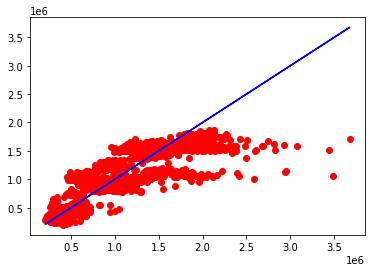

In [35]:
y_pred=LR.predict(X_test)
plt.plot(y_test,y_pred,'ro')
plt.plot(y_test,y_test,'b-')
plt.show()

In [36]:
Root_mean_square_error=np.sqrt(np.mean(np.square(y_test-y_pred)))
print(Root_mean_square_error)

324901.4408155921


In [37]:
from sklearn.metrics import r2_score
r2=r2_score(y_test,y_pred)
print(r2)

0.6562543540205228


In [38]:
prediction=LR.predict(pd.DataFrame([(40.37,2.876,173.325456,7.934,103464,0,0,0)]))
print(prediction)

[763719.14643706]


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


In [39]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42)

In [40]:
from sklearn.ensemble import RandomForestRegressor
clf_rf = RandomForestRegressor(n_estimators=150)
clf_rf.fit(x_train, y_train)
y_pred_rf=clf_rf.predict(x_val)
acc_rf= round(clf_rf.score(x_train, y_train) * 100, 2)
print ("Accuracy: %i %% \n"%acc_rf)


Accuracy: 99 % 

